In [85]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import re
import umap
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

'''
Variables: 

---------

corpus : list of documents
embeddings : documents embeddings of size NxM (N : number of documents, M : embedding dimension) 
red_emd : reduced embeddings matrix using dimentionality reduction
k : number of clusters
labels : documents labels
pred : list of clustering predicted clusters 

''';

In [86]:
def dim_red(mat, p):
    '''
    Perform dimensionality reduction

    Input:
    -----
        mat : NxM list 
        p : number of dimensions to keep 
    Output:
    ------
        red_mat : NxP list such that p<<m
    '''
    umap_model = umap.UMAP(n_components=p, n_neighbors=35,
            min_dist=0.1,
            metric="cosine",
            random_state=42,)
    red_mat = umap_model.fit_transform(mat)
    # red_mat = mat[:,:p]
    
    return red_mat

In [87]:
def clust(mat, k):
    '''
    Perform clustering

    Input:
    -----
        mat : input list 
        k : number of cluster
    Output:
    ------
        pred : list of predicted labels
    '''
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    pred = kmeans.fit_predict(mat)
    # pred = np.random.randint(k, size=len(corpus))
    
    return pred

In [88]:
# import data
ng20 = fetch_20newsgroups(subset='test')
corpus = ng20.data[:2000]
labels = ng20.target[:2000]
k = len(set(labels))


In [89]:
# embedding
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(corpus)

# perform dimentionality reduction
red_emb = dim_red(embeddings, 20)

# perform clustering
pred = clust(red_emb, k)

# evaluate clustering results
nmi_score = normalized_mutual_info_score(pred,labels)
ari_score = adjusted_rand_score(pred,labels)

print(f'NMI: {nmi_score:.2f} \nARI: {ari_score:.2f}')

NMI: 0.48 
ARI: 0.31


<Figure size 1200x1000 with 0 Axes>

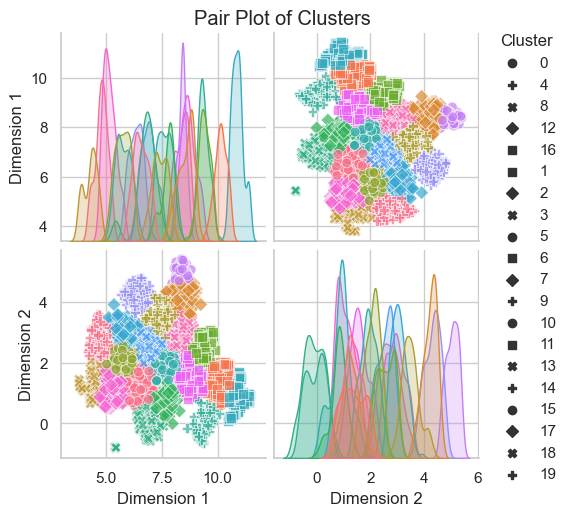

In [90]:
# Visualize UMAP with 2 Dimensions

# perform dimentionality reduction
red_emb = dim_red(embeddings, 2)

# perform clustering
pred = clust(red_emb, k)

# Combine data and cluster labels into a DataFrame
data_df = pd.DataFrame(red_emb, columns=['Dimension 1', 'Dimension 2'])
data_df['Cluster'] = pred

# Set Seaborn style
sns.set(style='whitegrid')

# Plot pair plot with enhanced aesthetics
plt.figure(figsize=(12, 10))
sns.pairplot(
    data_df,
    hue='Cluster',
    palette='husl',
    markers=["o", "s", "D", "X", "P"],
    diag_kind='kde',  # Kernel density estimation on the diagonal
    plot_kws={'alpha': 0.7, 's': 50},
)
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()

In [91]:
corpus_df = pd.DataFrame({'corpus': corpus, 'labels': labels, 'pred': pred})
corpus_df

,corpus,labels,pred
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7,14
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5,17
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0,1
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17,9
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19,11
...,...,...,...
1995,Organization: Queen's University at Kingston\n...,12,5
1996,From: stevek@cellar.org (Steve Kraisler)\nSubj...,16,6
1997,From: pmetzger@snark.shearson.com (Perry E. Me...,11,10
1998,From: d89-mad@ludd.luth.se (Mattias ]slund)\nS...,2,17


In [92]:
# Data Cleaning Pipeline
labels_names = ng20.target_names[:2000]

# Creating a dataframe from the loaded data
news_df = pd.DataFrame({'news': corpus, 
                        'class': labels})

In [93]:
news_df.head()

,news,class
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19


In [94]:
# preprocessing the text
def clean_text(text):
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove @mention
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    
    # remove twitter tags
    text = text.replace("<@>", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove unwanted punctuations
    text = re.sub('[%s]' % re.escape(""""#$%&'()*+-/,:;<=>[\]^_`{|}~•"""), ' ', text)
    
    # remove extra whitespace
    text = re.sub('\s+', ' ', text) 

    return text.lower()

news_df["cleaned_text"] = news_df["news"].apply(lambda x: clean_text(x))

In [95]:
news_df

,news,class,cleaned_text
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7,from v064mb9k.cc.buffalo.edu neil b. gandler s...
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5,from rick miller rick.uwm.edu subject x face? ...
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0,from mathew mathew.co.uk subject re strong wea...
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17,from bakken.arizona.edu dave bakken subject re...
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19,from livesey.wpd.sgi.com jon livesey subject r...
...,...,...,...
1995,Organization: Queen's University at Kingston\n...,12,organization queen s university at kingston fr...
1996,From: stevek@cellar.org (Steve Kraisler)\nSubj...,16,from stevek.org steve kraisler subject re atf ...
1997,From: pmetzger@snark.shearson.com (Perry E. Me...,11,from pmetzger.shearson.com perry e. metzger su...
1998,From: d89-mad@ludd.luth.se (Mattias ]slund)\nS...,2,from d89 mad.luth.se mattias slund subject rem...


In [96]:
news_df.cleaned_text

0       from v064mb9k.cc.buffalo.edu neil b. gandler s...
1       from rick miller rick.uwm.edu subject x face? ...
2       from mathew mathew.co.uk subject re strong wea...
3       from bakken.arizona.edu dave bakken subject re...
4       from livesey.wpd.sgi.com jon livesey subject r...
                              ...                        
1995    organization queen s university at kingston fr...
1996    from stevek.org steve kraisler subject re atf ...
1997    from pmetzger.shearson.com perry e. metzger su...
1998    from d89 mad.luth.se mattias slund subject rem...
1999    from shenton.gsfc.nasa.gov chris shenton subje...
Name: cleaned_text, Length: 2000, dtype: object

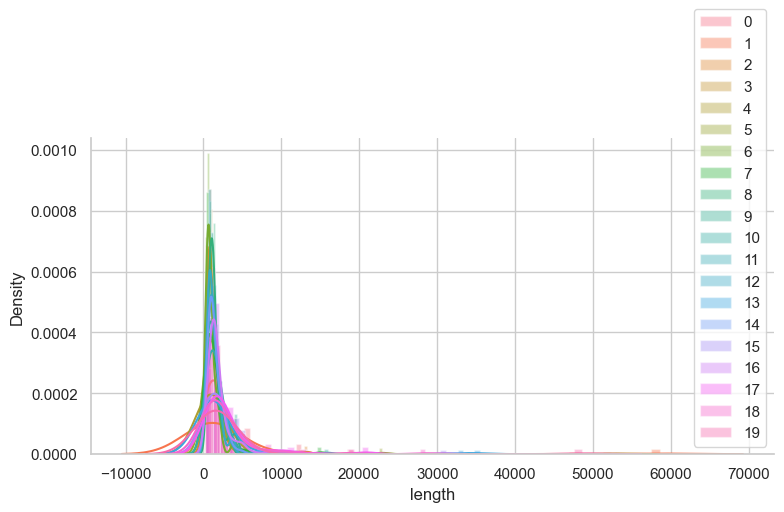

In [97]:
# making length a feature for visualizations
news_df['length']= news_df['news'].apply(len)
g=sns.FacetGrid(news_df,hue='class',height=4,aspect=2)
g=g.map(sns.distplot,'length')
plt.legend()

In [98]:
texts = news_df["cleaned_text"]

In [100]:
# embedding
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(texts)

# perform dimentionality reduction
red_emb = dim_red(embeddings, 20)

# perform clustering
pred = clust(red_emb, k)

# evaluate clustering results
nmi_score = normalized_mutual_info_score(pred,labels)
ari_score = adjusted_rand_score(pred,labels)

print(f'NMI: {nmi_score:.2f} \nARI: {ari_score:.2f}')

NMI: 0.56 
ARI: 0.37


<Figure size 1200x1000 with 0 Axes>

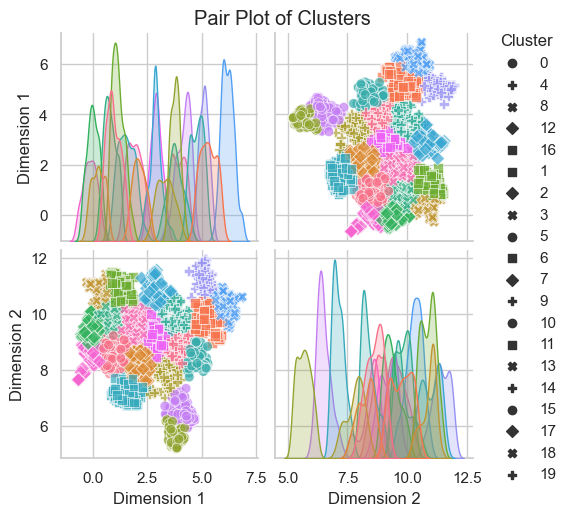

In [102]:
# perform dimentionality reduction
red_emb = dim_red(embeddings, 2)

# perform clustering
pred = clust(red_emb, k)

# Combine data and cluster labels into a DataFrame
data_df = pd.DataFrame(red_emb, columns=['Dimension 1', 'Dimension 2'])
data_df['Cluster'] = pred

# Set Seaborn style
sns.set(style='whitegrid')

# Plot pair plot with enhanced aesthetics
plt.figure(figsize=(12, 10))
sns.pairplot(
    data_df,
    hue='Cluster',
    palette='husl',
    markers=["o", "s", "D", "X", "P"],
    diag_kind='kde',  # Kernel density estimation on the diagonal
    plot_kws={'alpha': 0.7, 's': 50},
)
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()